In [70]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

import pandas_datareader.data as web
from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230926)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

from tabulate import tabulate

%matplotlib inline

In [2]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

In [3]:
# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

In [4]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [5]:
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

In [72]:
class Backtest:
    def __init__(self,data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        #print(f"Cummulative return is: {res:.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")
        return res
    
    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        #print(f"Max Drawdown: {res:.2f}%")
        return res
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        #print(f"Sharpe Ratio: {res:.3f}")
        return res
    
    def calculate_sortino_ratio(self):
        res= np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / np.minimum(self.data['Adj return'].dropna().apply(np.exp).add(-1),0).std()
        return res

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        #print(f"Strategy CAGR is: {CAGR:.2f}%")
        return CAGR
        
    def generate_quarterly_returns(self):
        self.data['quarter'] = self.data.index.quarter
        self.data['year'] = self.data.index.year
        result =\
        (
            self.data
            .groupby(['quarter', 'year'])['Adj return']
            .sum()
            .apply(np.exp)
            .add(-1)
            .multiply(100)
            .reset_index(name='Cumulative Return')
        )

        pivot=result.pivot(index='year', columns='quarter', values='Cumulative Return')
        pivot.columns=pivot.columns.map(lambda x: 'Q' + str(x))
        pivot=pivot.round(decimals=5)
        return pivot
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Asset Return")
        ax.legend(["Asset Cumm Return","Strategy Cumm Return (Adj)"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
    
        portfolio_stats = pd.DataFrame({
            'Final Account Balance': f"$ {self.data['Adj Capital'].iloc[-1]:,.2f}",
            'Cummulative return': f"{self.calculate_cumm_return():.2f}%",
            'Strategy CAGR': f"{self.calculate_cagr():.2f}%",
            'Max Drawdown': f"{self.calculate_max_drawdown():.2f}%",
            'Sharpe Ratio': f"{self.calculate_sharpe_ratio():.3f}",
            'Sortino Ratio': f"{self.calculate_sortino_ratio():.3f}"
        }, index=['Value'])

        portfolio_stats.columns.name='Statistic'

        print(tabulate(portfolio_stats.transpose(), headers='keys', tablefmt='pretty', showindex=True,stralign='right'))

#         print(f"Cummulative return is: {self.calculate_cumm_return():.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")
#         print(f"Strategy CAGR is: {self.calculate_cagr():.2f}%")
#         print(f"Max Drawdown: {self.calculate_max_drawdown():.2f}%")
#         print(f"Sharpe Ratio: {self.calculate_sharpe_ratio():.3f}")
#         print(f"Sortino Ratio: {self.calculate_sortino_ratio():.3f}")
        self.plot_backtest_returns()
        print('% Return by Quarter:')
        print(tabulate(self.generate_quarterly_returns(), headers='keys', tablefmt='pretty', showindex=True,stralign='right'))
        self.plot_backtest_buy_sell()


In [42]:
start="2004-11-1"
end="2023-11-1"

stock_ticker = ["SPY",'^VIX','ES=F','CL=F','IEF','ZB=F']

currency_ticker = ["DEXJPUS", "DEXUSUK"]

index_ticker = ["^IXIC", "DJIA", "^GDAXI","^HSI","^N225"]


stock_data = pdr.get_data_yahoo(stock_ticker,start=start,end=end)
#currency_data = pdr.get_data_fred(currency_ticker)
index_data = pdr.get_data_yahoo(index_ticker,start=start,end=end)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  5 of 5 completed


In [43]:
stock_data

Adj Close                                                         \
                 CL=F     ES=F        IEF         SPY        ZB=F       ^VIX   
Date                                                                           
2004-11-01  50.130001  1130.75  52.783993   78.617943  113.125000  16.270000   
2004-11-02  49.619999  1130.50  52.913219   78.645638  113.250000  16.180000   
2004-11-03  50.880001  1145.00  52.894760   79.636070  113.437500  14.040000   
2004-11-04  48.820000  1160.50  52.863998   80.723465  113.593803  13.970000   
2004-11-05  49.610001  1167.75  52.470173   81.229057  112.250000  13.840000   
...               ...      ...        ...         ...         ...        ...   
2023-10-25  85.389999  4209.75  89.011925  417.549988  108.406250  20.190001   
2023-10-26  83.209999  4156.50  89.690033  412.549988  109.875000  20.680000   
2023-10-27  85.540001  4137.75  89.829643  410.679993  109.500000  21.270000   
2023-10-30  82.309998  4185.75  89.530472  415.589996  109.281250  19.750000   
2023-10-31  81.019997  4212.25  89.340996  418.200012  109.437500  18.139999   

                Close                                  ...       Open  \
                 CL=F     ES=F        IEF         SPY  ...        IEF   
Date                                                   ...              
2004-11-01  50.130001  1130.75  85.779999  113.510002  ...  86.059998   
2004-11-02  49.619999  1130.50  85.989998  113.550003  ...  85.809998   
2004-11-03  50.880001  1145.00  85.959999  114.980003  ...  85.519997   
2004-11-04  48.820000  1160.50  85.910004  116.550003  ...  86.099998   
2004-11-05  49.610001  1167.75  85.269997  117.279999  ...  85.309998   
...               ...      ...        ...         ...  ...        ...   
2023-10-25  85.389999  4209.75  89.260002  417.549988  ...  89.580002   
2023-10-26  83.209999  4156.50  89.940002  412.549988  ...  89.349998   
2023-10-27  85.540001  4137.75  90.080002  410.679993  ...  89.870003   
2023-10-30  82.309998  4185.75  89.779999  415.589996  ...  89.639999   
2023-10-31  81.019997  4212.25  89.589996  418.200012  ...  89.830002   

                                                 Volume             \
                   SPY        ZB=F       ^VIX      CL=F       ES=F   
Date                                                                 
2004-11-01  113.559998  113.875000  16.430000  133138.0   494666.0   
2004-11-02  113.669998  113.250000  15.990000   82754.0   831105.0   
2004-11-03  115.029999  113.625000  15.050000  143701.0   981514.0   
2004-11-04  114.779999  113.312500  13.830000  121094.0   897586.0   
2004-11-05  117.050003  113.531303  13.670000  115766.0   833448.0   
...                ...         ...        ...       ...        ...   
2023-10-25  421.890015  110.281250  19.389999  429459.0  1981633.0   
2023-10-26  416.450012  108.406250  21.780001  341792.0  2419407.0   
2023-10-27  414.190002  109.781250  20.389999  333760.0  2195767.0   
2023-10-30  413.559998  109.687500  21.129999  356928.0  1904610.0   
2023-10-31  416.179993  109.000000  19.860001  346007.0  1836212.0   

                                                    
                   IEF          SPY      ZB=F ^VIX  
Date                                                
2004-11-01    128800.0   36720900.0  147349.0  0.0  
2004-11-02    191300.0   56210000.0  427746.0  0.0  
2004-11-03    139800.0   76960200.0  269523.0  0.0  
2004-11-04    435100.0   55350300.0  420930.0  0.0  
2004-11-05    886400.0   63287200.0  190298.0  0.0  
...                ...          ...       ...  ...  
2023-10-25  15170200.0   94223200.0  506995.0  0.0  
2023-10-26  15901300.0  115156800.0  596519.0  0.0  
2023-10-27  11628200.0  107367700.0  394682.0  0.0  
2023-10-30  11022500.0   86562700.0  441993.0  0.0  
2023-10-31  11574700.0   79665200.0  725179.0  0.0  

[4792 rows x 36 columns]

In [9]:
index_data.tail(15)

Adj Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2023-10-11  21.355377  15460.009766  17893.099609  13659.679688  31936.509766   
2023-10-12  21.385176  15425.030273  18238.210938  13574.219727  32494.660156   
2023-10-13  21.325577  15186.660156  17813.449219  13407.230469  32315.990234   
2023-10-16  21.544098  15237.990234  17640.359375  13567.980469  31659.029297   
2023-10-17  21.544098  15251.690430  17773.339844  13533.750000  32040.289062   
2023-10-18  21.256048  15094.910156  17732.519531  13314.299805  32042.250000   
2023-10-19  21.107058  15045.230469  17295.890625  13186.179688  31430.619141   
2023-10-20  20.968000  14798.469727  17172.130859  12983.809570  31259.359375   
2023-10-23  20.860001  14800.719727           NaN  13018.330078  30999.550781   
2023-10-24  21.020000  14879.940430  16991.529297  13139.870117  31062.349609   
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

                Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2023-10-11  21.500000  15460.009766  17893.099609  13659.679688  31936.509766   
2023-10-12  21.530001  15425.030273  18238.210938  13574.219727  32494.660156   
2023-10-13  21.469999  15186.660156  17813.449219  13407.230469  32315.990234   
2023-10-16  21.690001  15237.990234  17640.359375  13567.980469  31659.029297   
2023-10-17  21.690001  15251.690430  17773.339844  13533.750000  32040.289062   
2023-10-18  21.400000  15094.910156  17732.519531  13314.299805  32042.250000   
2023-10-19  21.250000  15045.230469  17295.890625  13186.179688  31430.619141   
2023-10-20  21.110001  14798.469727  17172.130859  12983.809570  31259.359375   
2023-10-23  20.860001  14800.719727           NaN  13018.330078  30999.550781   
2023-10-24  21.020000  14879.940430  16991.529297  13139.870117  31062.349609   
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

            ...       Open                                            \
            ...       DJIA        ^GDAXI          ^HSI         ^IXIC   
Date        ...                                                        
2023-10-11  ...  21.629999  15366.780273  17956.830078  13619.209961   
2023-10-12  ...  21.540001  15537.870117  18258.259766  13672.469727   
2023-10-13  ...  21.459999  15400.089844  17946.769531  13613.589844   
2023-10-16  ...  21.540001  15219.419922  17803.310547  13453.809570   
2023-10-17  ...  21.629999  15211.290039  17806.230469  13419.870117   
2023-10-18  ...  21.590000  15244.049805  17728.250000  13439.679688   
2023-10-19  ...  21.400000  15060.650391  17540.460938  13354.799805   
2023-10-20  ...  21.190001  14872.019531  17127.259766  13157.769531   
2023-10-23  ...  20.879999  14823.030273           NaN  12930.849609   
2023-10-24  ...  20.920000  14802.519531  17053.150391  13084.990234   
2023-10-25  ...  21.010000  14870.629883  17465.429688  13039.860352   
2023-10-26  ...  21.059999  14696.219727  17085.119141  12768.969727   
2023-10-27  ..

In [10]:
return_period = 5

In [11]:
Y =\
    (stock_data.loc[ : , ("Adj Close", "SPY")]
     .diff(return_period)
     .shift(-return_period)
    )
Y

Date
2004-11-01    2.493385
2004-11-02    2.306396
2004-11-03    1.378281
2004-11-04    0.907349
2004-11-05    1.045830
                ...   
2023-10-25         NaN
2023-10-26         NaN
2023-10-27         NaN
2023-10-30         NaN
2023-10-31         NaN
Name: (Adj Close, SPY), Length: 4792, dtype: float64

In [12]:
Y.name =\
    (Y
     .name[-1]
     +
     "_pred")

Y

Date
2004-11-01    2.493385
2004-11-02    2.306396
2004-11-03    1.378281
2004-11-04    0.907349
2004-11-05    1.045830
                ...   
2023-10-25         NaN
2023-10-26         NaN
2023-10-27         NaN
2023-10-30         NaN
2023-10-31         NaN
Name: SPY_pred, Length: 4792, dtype: float64

In [13]:
X1 =\
    (stock_data.loc[ : , ("Adj Close", ("CL=F", "ES=F","IEF","ZB=F","^VIX")
                             )
                       ]
     .diff(return_period)
    )

X1.columns =\
    (X1
     .columns
     .droplevel()
    )

X1

,CL=F,ES=F,IEF,ZB=F,^VIX
Date,,,,,
2004-11-01,NaN,NaN,NaN,NaN,NaN
2004-11-02,NaN,NaN,NaN,NaN,NaN
2004-11-03,NaN,NaN,NaN,NaN,NaN
2004-11-04,NaN,NaN,NaN,NaN,NaN
2004-11-05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-10-25,-2.930000,-132.50,-0.129631,-0.87500,0.970001
2023-10-26,-6.160004,-146.50,0.987259,2.03125,-0.719999
2023-10-27,-3.209999,-110.75,0.608307,1.03125,-0.439999


In [14]:
X2 =\
    (index_data.loc[ : , ("Adj Close", ("^GDAXI","^HSI","^IXIC","^N225")
                             )
                       ]
     .diff(return_period)
    )

X2.columns =\
    (X2
     .columns
     .droplevel()
    )

X2

,^GDAXI,^HSI,^IXIC,^N225
Date,,,,
2004-11-01,NaN,NaN,NaN,NaN
2004-11-02,NaN,NaN,NaN,NaN
2004-11-03,NaN,NaN,NaN,NaN
2004-11-04,NaN,NaN,NaN,NaN
2004-11-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-10-25,-202.730469,-647.189453,-493.080078,-772.330078
2023-10-26,-314.180664,-251.281250,-590.569336,-828.839844
2023-10-27,-111.059570,226.599609,-340.799805,-267.669922


In [15]:
index_data

Adj Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2004-11-01        NaN   4012.639893  13094.250000   1979.869995  10734.709961   
2004-11-02        NaN   4037.570068  13308.740234   1984.790039  10887.809570   
2004-11-03        NaN   4039.040039  13397.669922   2004.329956           NaN   
2004-11-04        NaN   4041.379883  13369.089844   2023.630005  10946.269531   
2004-11-05        NaN   4063.580078  13494.950195   2038.939941  11061.769531   
...               ...           ...           ...           ...           ...   
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

                Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2004-11-01        NaN   4012.639893  13094.250000   1979.869995  10734.709961   
2004-11-02        NaN   4037.570068  13308.740234   1984.790039  10887.809570   
2004-11-03        NaN   4039.040039  13397.669922   2004.329956           NaN   
2004-11-04        NaN   4041.379883  13369.089844   2023.630005  10946.269531   
2004-11-05        NaN   4063.580078  13494.950195   2038.939941  11061.769531   
...               ...           ...           ...           ...           ...   
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

            ...       Open                                            \
            ...       DJIA        ^GDAXI          ^HSI         ^IXIC   
Date        ...                                                        
2004-11-01  ...        NaN   3961.179932  13039.400391   1975.479980   
2004-11-02  ...        NaN   4017.830078  13160.080078   1981.469971   
2004-11-03  ...        NaN   4061.409912  13316.120117   2014.449951   
2004-11-04  ...        NaN   4032.610107  13485.889648   1998.150024   
2004-11-05  ...        NaN   4075.010010  13497.950195   2035.040039   
...         ...        ...           ...           ...           ...   
2023-10-25  ...  21.010000  14870.629883  17465.429688  13039.860352   
2023-10-26  ...  21.059999  14696.219727  17085.119141  12768.969727   
2023-10-27  ...  20.990000  14757.110352  17160.230469  12718.690430   
2023-10-30  ...  20.910000  14770.950195  17225.650391  12750.469727   
2023-10-31  ...  21.049999  14741.440430  17337.699219  12786.620117   

                           Volume                                           \
                   ^N225     DJIA       ^GDAXI          ^HSI         ^IXIC   
Date                                                                         
2004-11-01  10731.019531      NaN   65754300.0  1.984324e+08  1.522820e+09   
2004-11-02  10775.000000      NaN   88857800.0  3.862780e+08  1.845080e+09   
2004-11-03           NaN      NaN  112707800.0  3.527140e+08  1.957400e+09   
2004-11-04  10990.700195      NaN   85037600.0  3.084676e+08  1.823490e+09   
2004-11-05  11040.059570      NaN  123958100.0  3.623888e+08  1.908970e+09   
...                  ...      ...          ...           ...           ...   
2023-10-25  31302.509766   6600

In [16]:
X3 =\
    (
    pd
    .concat([np
             .log(stock_data.loc[ : , ("Adj Close", "SPY")
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X3.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]

In [17]:
X3

,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
Date,,,,
2005-01-26,-0.008409,-0.013556,-0.021719,0.039919
2005-01-27,-0.000596,-0.004927,-0.023498,0.041271
2005-01-28,0.005551,-0.009998,-0.024243,0.028756
2005-01-31,0.013720,-0.002367,-0.017466,0.021391
2005-02-01,0.017219,-0.000757,-0.004447,0.021475
...,...,...,...,...
2023-10-25,-0.029869,-0.016885,-0.063536,-0.085620
2023-10-26,-0.033091,-0.028555,-0.084169,-0.083658
2023-10-27,-0.025270,-0.044901,-0.076590,-0.085331


In [18]:
X=\
(
    pd
    .concat([X1, X2, X3],
            axis = 1)
)

X

,CL=F,ES=F,IEF,ZB=F,^VIX,^GDAXI,^HSI,^IXIC,^N225,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
Date,,,,,,,,,,,,,
2004-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,-2.930000,-132.50,-0.129631,-0.87500,0.970001,-202.730469,-647.189453,-493.080078,-772.330078,-0.029869,-0.016885,-0.063536,-0.085620
2023-10-26,-6.160004,-146.50,0.987259,2.03125,-0.719999,-314.180664,-251.281250,-590.569336,-828.839844,-0.033091,-0.028555,-0.084169,-0.083658
2023-10-27,-3.209999,-110.75,0.608307,1.03125,-0.439999,-111.059570,226.599609,-340.799805,-267.669922,-0.025270,-0.044901,-0.076590,-0.085331


In [19]:
X[60:70]

,CL=F,ES=F,IEF,ZB=F,^VIX,^GDAXI,^HSI,^IXIC,^N225,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
Date,,,,,,,,,,,,,
2005-01-24,0.430000,-17.50,0.204365,1.281303,2.219999,-43.619629,-234.660156,NaN,-197.609375,NaN,NaN,NaN,NaN
2005-01-25,1.259998,-26.00,0.024757,0.031197,1.590000,-16.759766,-20.160156,-86.090088,-146.349609,NaN,NaN,NaN,NaN
2005-01-26,1.230000,-10.25,0.006229,-0.031303,0.259999,-31.429688,-54.950195,-27.500122,-28.769531,-0.008409,-0.013556,-0.021719,0.039919
2005-01-27,1.930000,-1.75,-0.167206,-0.281303,-0.590000,-4.020020,85.320312,1.270020,56.540039,-0.000596,-0.004927,-0.023498,0.041271
2005-01-28,-1.349998,6.25,0.000000,0.281303,-1.120000,-11.890137,169.040039,1.559937,82.209961,0.005551,-0.009998,-0.024243,0.028756
2005-01-31,-0.610001,15.50,0.024788,0.125000,-1.830000,52.959961,334.700195,53.709961,98.099609,0.013720,-0.002367,-0.017466,0.021391
2005-02-01,-2.520000,19.50,0.186298,0.875000,-2.030001,46.020020,-5.799805,48.750000,107.490234,0.017219,-0.000757,-0.004447,0.021475
2005-02-02,-2.090000,20.00,0.180023,0.937500,-1.780000,82.189941,-67.879883,28.970093,30.569336,0.017252,0.009181,-0.001675,0.025948
2005-02-03,-2.389999,14.75,0.173618,0.937500,-1.450000,65.229980,-113.580078,10.489868,48.040039,0.012945,0.003284,-0.011949,0.025311


In [20]:
Y

Date
2004-11-01    2.493385
2004-11-02    2.306396
2004-11-03    1.378281
2004-11-04    0.907349
2004-11-05    1.045830
                ...   
2023-10-25         NaN
2023-10-26         NaN
2023-10-27         NaN
2023-10-30         NaN
2023-10-31         NaN
Name: SPY_pred, Length: 4792, dtype: float64

In [21]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

data

,SPY_pred,CL=F,ES=F,IEF,ZB=F,^VIX,^GDAXI,^HSI,^IXIC,^N225,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
Date,,,,,,,,,,,,,,
2005-01-26,1.423813,1.230000,-10.25,0.006229,-0.031303,0.259999,-31.429688,-54.950195,-27.500122,-28.769531,-0.008409,-0.013556,-0.021719,0.039919
2005-02-02,0.027901,-2.090000,20.00,0.180023,0.937500,-1.780000,82.189941,-67.879883,28.970093,30.569336,0.017252,0.009181,-0.001675,0.025948
2005-02-14,-1.451729,2.160000,5.50,-0.024837,-0.250000,-0.209999,20.049805,222.230469,0.879883,132.339844,0.005067,0.034822,-0.001573,0.020919
2005-03-01,0.767708,0.529999,25.25,-0.309963,-0.750000,-1.100000,60.410156,-29.369141,40.930054,182.820312,0.021933,0.009615,0.024973,0.020510
2005-03-08,-1.528511,2.910000,10.50,-0.037357,0.281197,0.360000,12.879883,-179.440430,2.300049,106.379883,0.009032,0.013580,0.048402,0.030548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,-17.386993,3.290001,49.75,-0.109406,-0.250000,-1.580000,86.629883,-154.150391,177.219727,177.023438,0.012310,0.016410,0.000511,0.029702
2023-09-26,-4.290009,-0.809998,-175.25,-1.104027,-4.000000,4.830001,-408.610352,-530.269531,-614.580078,-927.539062,-0.038757,-0.049879,-0.047360,-0.036523
2023-10-04,11.660004,-9.459999,-15.75,-0.649895,-2.000000,0.360001,-117.530273,-416.029297,143.160156,-1845.019531,-0.003268,-0.046652,-0.027751,-0.037540


In [22]:
data

,SPY_pred,CL=F,ES=F,IEF,ZB=F,^VIX,^GDAXI,^HSI,^IXIC,^N225,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
Date,,,,,,,,,,,,,,
2005-01-26,1.423813,1.230000,-10.25,0.006229,-0.031303,0.259999,-31.429688,-54.950195,-27.500122,-28.769531,-0.008409,-0.013556,-0.021719,0.039919
2005-02-02,0.027901,-2.090000,20.00,0.180023,0.937500,-1.780000,82.189941,-67.879883,28.970093,30.569336,0.017252,0.009181,-0.001675,0.025948
2005-02-14,-1.451729,2.160000,5.50,-0.024837,-0.250000,-0.209999,20.049805,222.230469,0.879883,132.339844,0.005067,0.034822,-0.001573,0.020919
2005-03-01,0.767708,0.529999,25.25,-0.309963,-0.750000,-1.100000,60.410156,-29.369141,40.930054,182.820312,0.021933,0.009615,0.024973,0.020510
2005-03-08,-1.528511,2.910000,10.50,-0.037357,0.281197,0.360000,12.879883,-179.440430,2.300049,106.379883,0.009032,0.013580,0.048402,0.030548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,-17.386993,3.290001,49.75,-0.109406,-0.250000,-1.580000,86.629883,-154.150391,177.219727,177.023438,0.012310,0.016410,0.000511,0.029702
2023-09-26,-4.290009,-0.809998,-175.25,-1.104027,-4.000000,4.830001,-408.610352,-530.269531,-614.580078,-927.539062,-0.038757,-0.049879,-0.047360,-0.036523
2023-10-04,11.660004,-9.459999,-15.75,-0.649895,-2.000000,0.360001,-117.530273,-416.029297,143.160156,-1845.019531,-0.003268,-0.046652,-0.027751,-0.037540


In [23]:
Y = data.loc[ : , Y.name]
Y

Date
2005-01-26     1.423813
2005-02-02     0.027901
2005-02-14    -1.451729
2005-03-01     0.767708
2005-03-08    -1.528511
                ...    
2023-09-14   -17.386993
2023-09-26    -4.290009
2023-10-04    11.660004
2023-10-12    -7.230011
2023-10-20   -10.510010
Name: SPY_pred, Length: 725, dtype: float64

In [24]:
X = data.loc[ : , X.columns]
X

,CL=F,ES=F,IEF,ZB=F,^VIX,^GDAXI,^HSI,^IXIC,^N225,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
Date,,,,,,,,,,,,,
2005-01-26,1.230000,-10.25,0.006229,-0.031303,0.259999,-31.429688,-54.950195,-27.500122,-28.769531,-0.008409,-0.013556,-0.021719,0.039919
2005-02-02,-2.090000,20.00,0.180023,0.937500,-1.780000,82.189941,-67.879883,28.970093,30.569336,0.017252,0.009181,-0.001675,0.025948
2005-02-14,2.160000,5.50,-0.024837,-0.250000,-0.209999,20.049805,222.230469,0.879883,132.339844,0.005067,0.034822,-0.001573,0.020919
2005-03-01,0.529999,25.25,-0.309963,-0.750000,-1.100000,60.410156,-29.369141,40.930054,182.820312,0.021933,0.009615,0.024973,0.020510
2005-03-08,2.910000,10.50,-0.037357,0.281197,0.360000,12.879883,-179.440430,2.300049,106.379883,0.009032,0.013580,0.048402,0.030548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,3.290001,49.75,-0.109406,-0.250000,-1.580000,86.629883,-154.150391,177.219727,177.023438,0.012310,0.016410,0.000511,0.029702
2023-09-26,-0.809998,-175.25,-1.104027,-4.000000,4.830001,-408.610352,-530.269531,-614.580078,-927.539062,-0.038757,-0.049879,-0.047360,-0.036523
2023-10-04,-9.459999,-15.75,-0.649895,-2.000000,0.360001,-117.530273,-416.029297,143.160156,-1845.019531,-0.003268,-0.046652,-0.027751,-0.037540


In [25]:
data.describe()

,SPY_pred,CL=F,ES=F,IEF,ZB=F,^VIX,^GDAXI,^HSI,^IXIC,^N225,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000
mean,0.526180,0.123559,2.700800,0.019040,-0.043276,0.059297,7.694437,-0.532026,9.515702,15.787591,0.001665,0.004148,0.009890,0.021729
std,5.182231,3.465219,60.877004,0.769192,2.081091,3.708021,274.924075,665.642937,205.389983,514.516503,0.026282,0.041535,0.056479,0.076961
min,-51.242477,-14.400002,-546.500000,-3.903275,-7.562500,-25.580002,-2783.589844,-4307.169922,-1536.790039,-2769.488281,-0.198077,-0.306062,-0.352248,-0.440879
25%,-1.224052,-1.879997,-17.500000,-0.412155,-1.218697,-1.600002,-119.850098,-379.660156,-46.600098,-222.830078,-0.009717,-0.011404,-0.011037,-0.005915
50%,0.581009,0.290001,6.500000,0.079716,0.031250,-0.210000,25.419922,39.419922,14.669922,33.291016,0.003973,0.010227,0.017275,0.034306
75%,2.360970,2.190002,28.750000,0.448044,1.125000,1.280001,148.050293,415.898438,76.030029,311.980469,0.014739,0.026802,0.042280,0.064735
max,20.989563,14.860001,390.750000,3.175827,18.187500,35.850002,1307.689453,2534.169922,913.479980,2197.191406,0.177339,0.159501,0.194367,0.325573


<Axes: title={'center': 'Correlation Matrix'}>

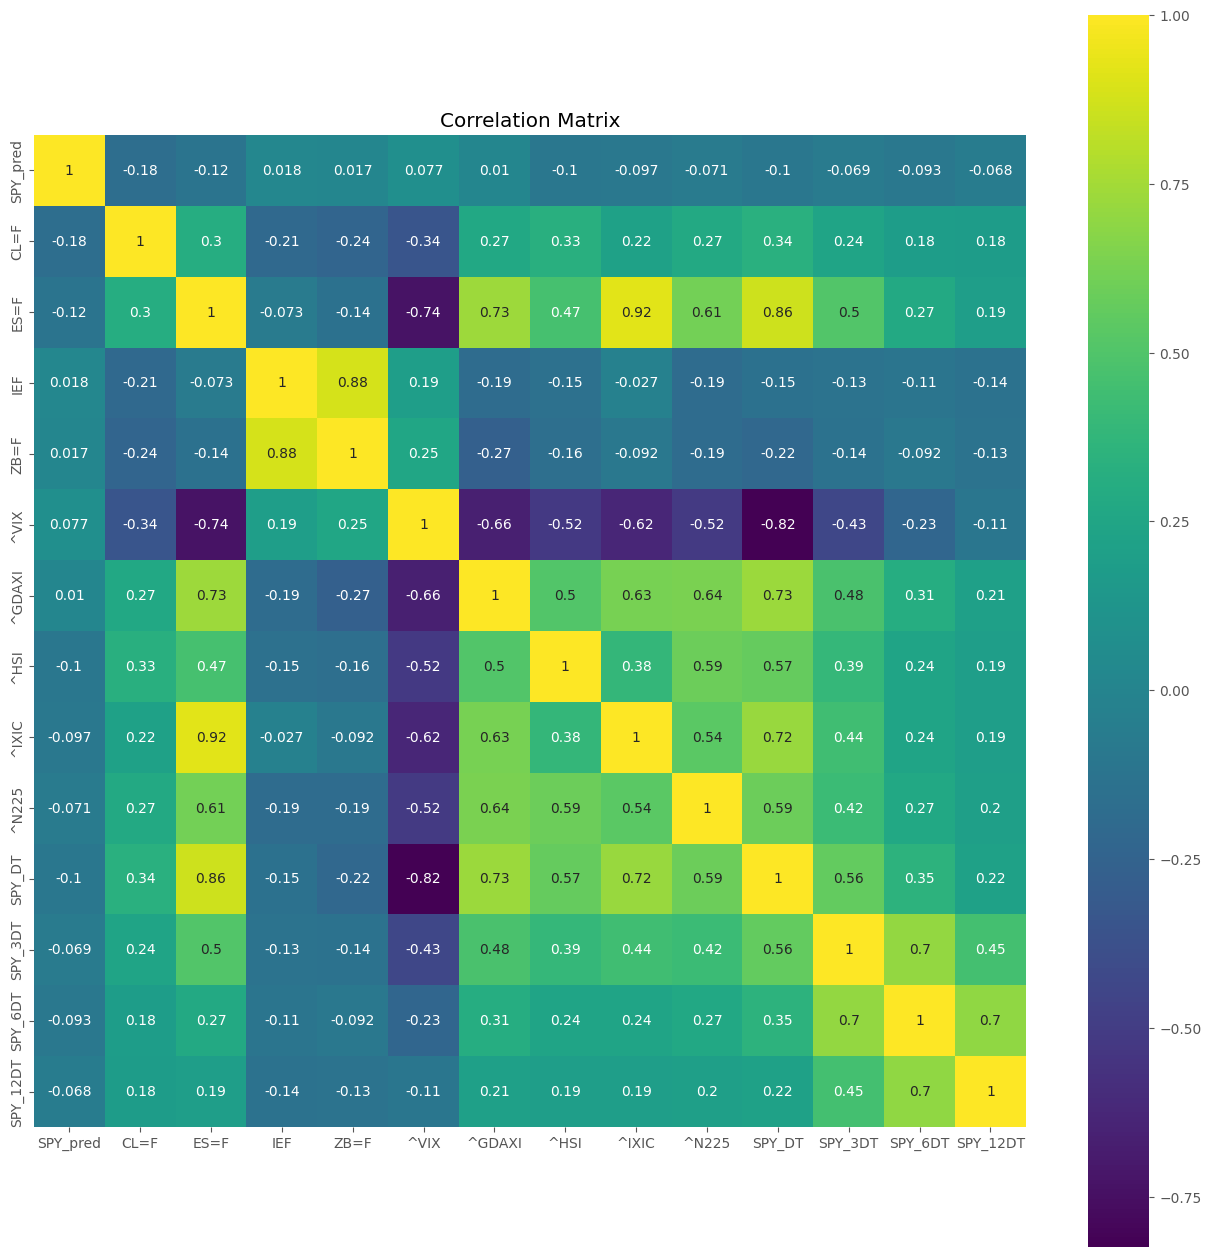

In [26]:
correlation = data.corr()

plt.figure(figsize =[16, 16]
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            cmap = "viridis",
            annot = True)

In [27]:
validation_size = 0.20  ## This is not the conventional validation set -- this is testing set

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [28]:
num_folds = 10
seed = 230926
scoring = "neg_mean_squared_error"

In [29]:
models = []

In [30]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

In [31]:
# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [32]:
# Gift for you

# Team, let me guide you through this step-by-step

### Initialization of Lists:

names = []

kfold_results = []

train_results = []
test_results = []

# Four empty lists are initialized. 
# names will store the names of the models, 
# kfold_results will store the cross-validation results, 
# train_results and test_results 
# will store the performance of the models 
# on the training and testing datasets, respectively.

### Looping through Models:

# Let's iterate over a list of models. 

# Each element in the models list is a tuple 
# containing the name of the model (name) and the model object (model).

for name, model in models:
    
### Appending Model Names:

# The name of the current model is appended to the names list.

    names.append(name)
    
### Let's run K-fold Cross-Validation
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
# A KFold object is created with a specified number of splits (num_folds), 
# a random seed (seed), 
# and shuffling enabled.
    
### Running Cross-Validation:
# Let's convert MSE to positive (Here, now it becomes lower the better; See below)

    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
        
# Cross-validation is performed on the training data (X_train, Y_train) using the current model. 
# The negative mean squared error is used 
# as the scoring metric 
# (hence multiplied by -1 to make it positive, 
# as the convention is that higher scores are better).

# Storing Cross-Validation Results:
 
### The cross-validation results for the current model are appended to the kfold_results list.    
    
    kfold_results.append(cv_results)

# Fitting the Model on the Entire Training Set:
  
    res = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

### Evaluating Model on Training Set:

# The trained model’s predictions on the training set are evaluated 
# using the mean squared error, and the result is appended to train_results.

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    
    train_results.append(train_result)

## Evaluating Model on Testing Set:    
    
# Similarly, the model’s performance is evaluated 
# on the testing set and appended to test_results.
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)
    
# Printing the Results:

# The name of the model, 
# the average cross-validation score, 
# the standard deviation of the cross-validation scores, 
# the training set performance, 
# and the testing set performance are printed out.

    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

LR: 9.175841 (4.223564) 8.298696 98.997312
LASSO: 9.018261 (4.321615) 8.513713 96.503032
EN: 9.015926 (4.299563) 8.449945 96.718050
CART: 20.220772 (6.319645) 0.000000 117.542741
KNN: 10.551302 (5.189058) 6.859106 104.434867
SVR: 9.153329 (4.342477) 8.489788 100.986498
RFR: 10.221202 (3.927749) 1.520091 102.815580
ETR: 10.267737 (4.506291) 0.000000 101.715178
GBR: 10.610866 (4.063068) 2.821899 101.979001
ABR: 9.860039 (4.416421) 5.735131 98.786767


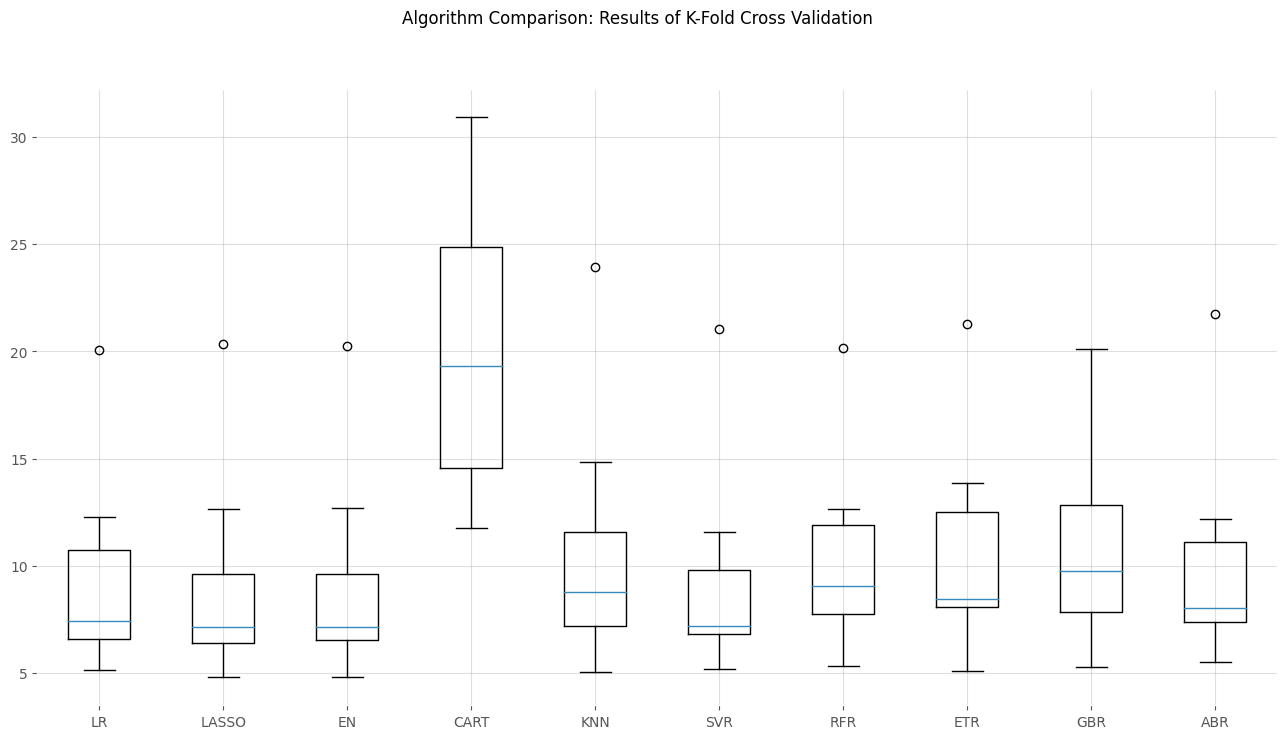

In [33]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

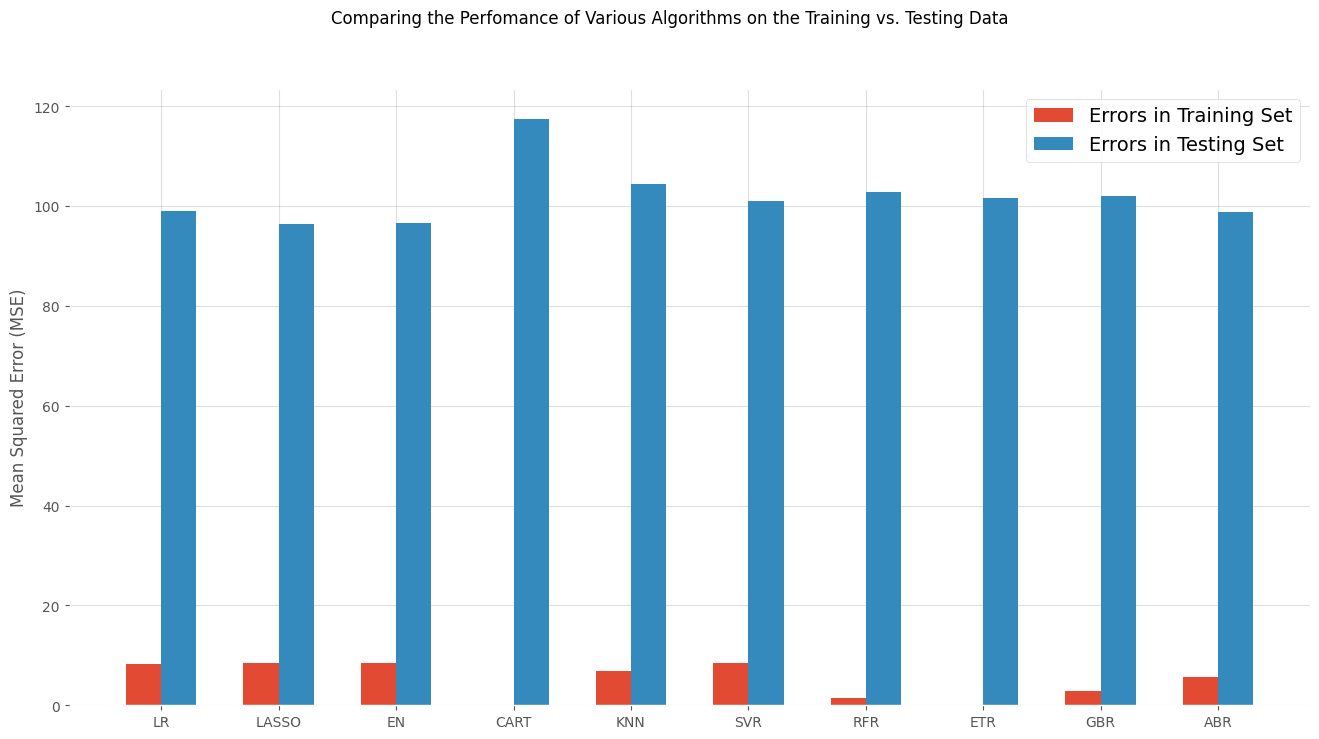

In [34]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
    
      # Team, this line calculates the starting x position of the bars 
      # representing "Errors in Training Set". 
      # The width/2 term is used to shift the bars to the left, 
      # so they are centered around the tick mark for each group (algorithm) on the x-axis.
      
      # The bar chart will have two sets of bars for each algorithm: 
      # one for training errors and one for testing errors. 
      
      # By subtracting width/2 from ind, 
      # the training error bars are positioned to the left of the center of the tick marks. 
      
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

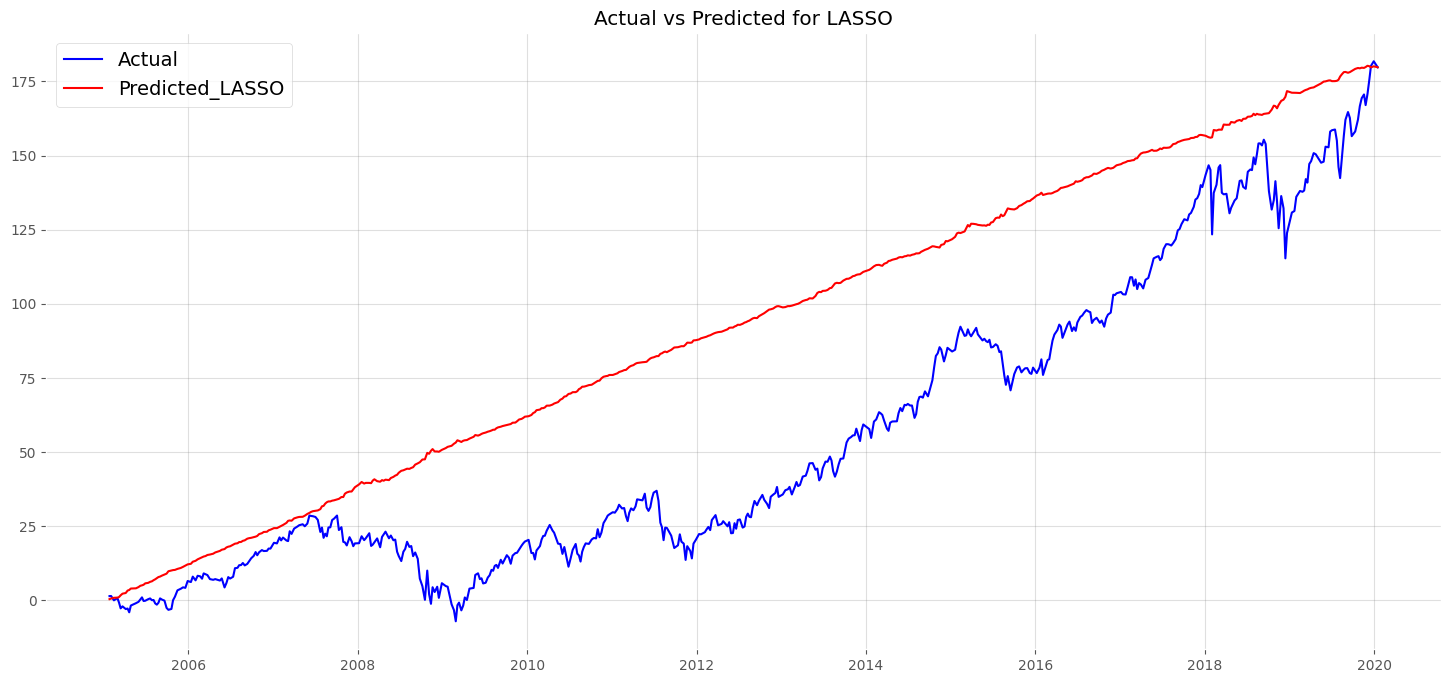

In [85]:
models_to_consider=['LASSO']
for name,model in models:
    if (name in models_to_consider):
        plt.figure(figsize=[18,8])
        fitted_model = model.fit(X_train, Y_train)
        predicted_y = model.predict(X_train)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.index=Y_train.index
        plt.plot(Y_train.cumsum(),color='b',label='Actual')
        plt.plot(predicted_y.cumsum(),color='r',label=f"Predicted_{name}")
        plt.legend()
        plt.title(f"Actual vs Predicted for {name}")
        plt.show()

In [48]:
np.exp(Y_train.sum())

1.2003429214174222e+78

In [86]:
models_to_consider=['LASSO']
for name,model in models:
    if (name in models_to_consider):
        fitted_model = model.fit(X_train, Y_train)
        predicted_y = model.predict(X_test)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.columns=['prediction']
        predicted_y.index=Y_test.index
        print(name)
        print(np.sign(Y_test*predicted_y['prediction']).value_counts())

LASSO
 1.0    85
-1.0    60
Name: count, dtype: int64


In [87]:
predicted_y['Position']=np.where(predicted_y['prediction']>0,1,-1)
test_data=(stock_data.loc[ : , ("Adj Close", "SPY")])
test_data.name='Adj Close'
test_data=test_data.to_frame()
final_data=pd.concat([test_data,predicted_y['Position']],axis=1)
final_data=final_data.fillna(method='ffill')
final_data=final_data.dropna()

In [64]:
predicted_y

,prediction,Position
Date,,
2005-01-26,1.423813,1
2005-02-02,0.027901,1
2005-02-14,-1.451729,-1
2005-03-01,0.767708,1
2005-03-08,-1.528511,-1
...,...,...
2019-12-03,3.734100,1
2019-12-11,4.850525,1
2019-12-18,4.632721,1


In [66]:
final_data

,Adj Close,Position
Date,,
2005-01-26,81.819740,1.0
2005-01-27,81.959343,1.0
2005-01-28,81.959343,1.0
2005-01-31,82.468864,1.0
2005-02-01,82.992279,1.0
...,...,...
2023-10-25,417.549988,-1.0
2023-10-26,412.549988,-1.0
2023-10-27,410.679993,-1.0


+-----------------------+--------------+
|             Statistic |        Value |
+-----------------------+--------------+
| Final Account Balance | $ 218,717.97 |
|    Cummulative return |      122.28% |
|         Strategy CAGR |       23.60% |
|          Max Drawdown |      -20.28% |
|          Sharpe Ratio |        1.028 |
|         Sortino Ratio |        1.775 |
+-----------------------+--------------+


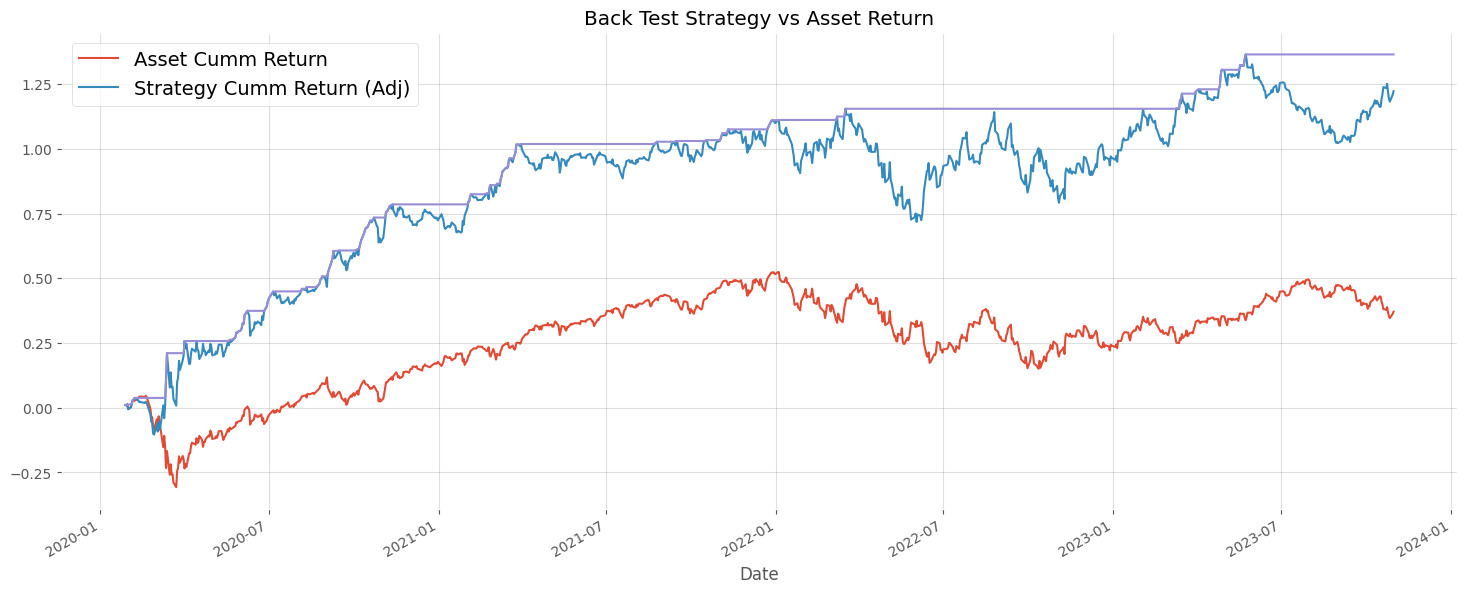

% Return by Quarter:
+------+----------+----------+----------+---------+
| year |       Q1 |       Q2 |       Q3 |      Q4 |
+------+----------+----------+----------+---------+
| 2020 | 20.11529 | 17.35047 | 12.72551 | 8.49815 |
| 2021 | 17.10346 | -2.28305 | -1.06596 | 7.57531 |
| 2022 | -0.07244 | -8.76103 | -4.33838 | 7.36052 |
| 2023 | 13.00885 |  1.48058 |  -4.9346 | 3.70767 |
+------+----------+----------+----------+---------+


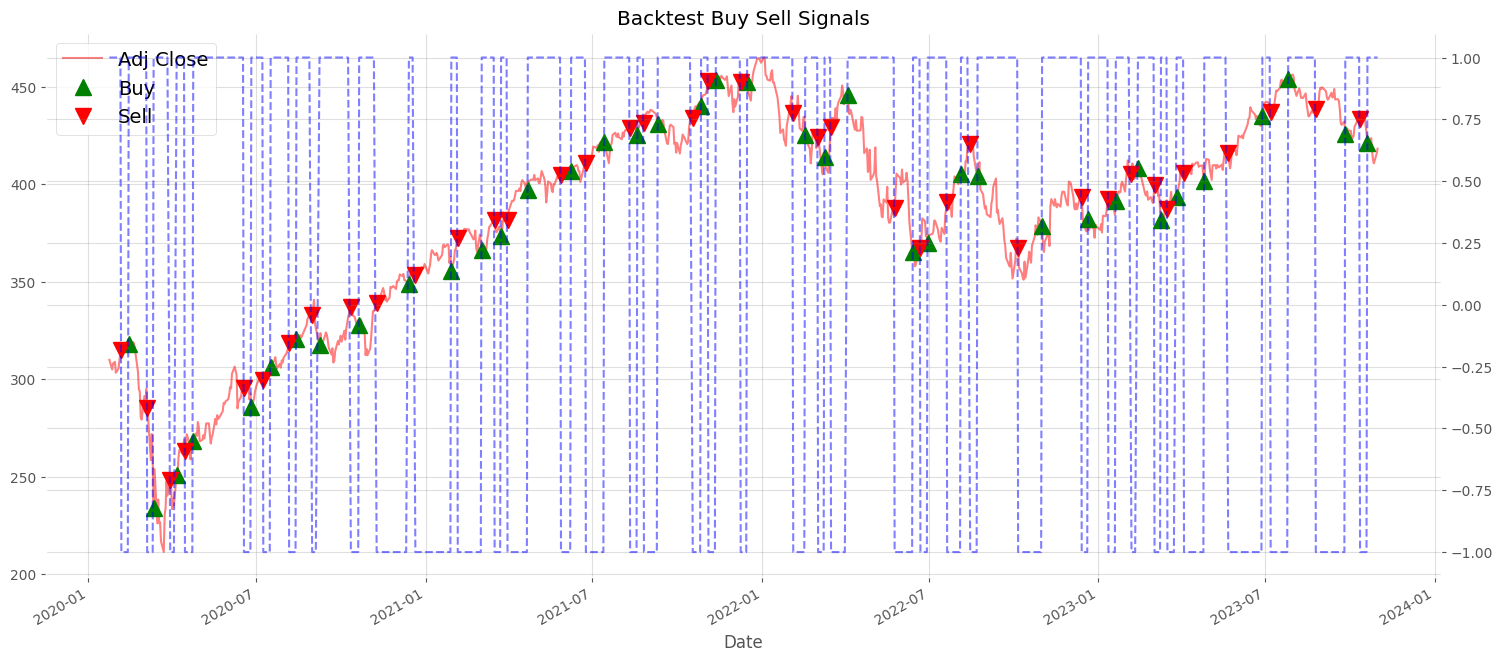

In [88]:
Backtest_ML_Strategy=Backtest(final_data,100000,0)
Backtest_ML_Strategy.plot_all_stats()